In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
sys.path.append('..')

from detectors.feature_based import *

from detectors.gaussian_distribution_based import *
from detectors.ml_based import *

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ['SCIPY_USE_PROPACK'] = "True"
 
threads = "64"
os.environ["OMP_NUM_THREADS"] = threads
os.environ["OPENBLAS_NUM_THREADS"] = threads
os.environ["MKL_NUM_THREADS"] = threads
os.environ["VECLIB_MAXIMUM_THREADS"] = threads
os.environ["NUMEXPR_NUM_THREADS"] = threads

In [2]:
import torchattacks

import torch
from tensordict import TensorDict
from tensordict import MemoryMappedTensor as MMT

import abc  

In [3]:
# python stuff

from pathlib import Path as Path
from numpy.random import randint
from tqdm import tqdm

# Our stuff
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap
from adv_atk.attacks_base import fds, ftd
from coreVectors.coreVectors import CoreVectors 
from coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn
from classifier.classifier_base import trim_corevectors

# from credibility import get_credibility

# torch stuff
from torchvision.models import vgg16, VGG16_Weights
from cuda_selector import auto_cuda

# use_cuda = torch.cuda.is_available()
# device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device("cpu")
# print(f"Using {device} device")
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

#--------------------------------
# Directories definitions
#--------------------------------
ds_path = '/srv/newpenny/dataset/CIFAR100'

# model parameters
pretrained = True
name_model = 'vgg16'
dataset = 'CIFAR100' 
seed = 29
bs = 64

model_dir = '/srv/newpenny/XAI/models'
model_name = 'LM_model=vgg16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau.pth'

svds_name = 'svds' 
svds_path = f'/srv/newpenny/XAI/generated_data/svds/{dataset}/{name_model}'

cvs_name = 'corevectors'
cvs_path = f'/srv/newpenny/XAI/generated_data/corevectors/{dataset}/{name_model}'

verbose = True

#--------------------------------
# Dataset 
#--------------------------------
ds = Cifar(dataset=dataset, data_path=ds_path)
ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

Using cuda:5 device
dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f6c537d5670>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f6c54d45250>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f6c537d5760>}

In [4]:
#--------------------------------
# Model 
#--------------------------------

nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
num_classes = len(ds.get_classes()) 
nn.classifier[-1] = torch.nn.Linear(in_features, num_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, path=model_dir, name=model_name, verbose=True)

target_layers = [
            'classifier.0',
            'classifier.3',
            'features.7',
            'features.14',
            'features.28'
            ]
model.set_target_layers(target_layers=target_layers, verbose=True)

direction = {'save_input':True, 'save_output':False}
model.add_hooks(**direction, verbose=False) 

dry_img, _ = ds._train_ds.dataset[0]
dry_img = dry_img.reshape((1,)+dry_img.shape)
model.dry_run(x=dry_img)

#--------------------------------
# SVDs 
#--------------------------------
print('target layers: ', model.get_target_layers()) 
model.get_svds(path=svds_path, name=svds_name, verbose=verbose)
for k in model._svds.keys():
    for kk in model._svds[k].keys():
        print('svd shapes: ', k, kk, model._svds[k][kk].shape)
        
#--------------------------------
# CoreVectors 
#--------------------------------
ds_loaders = ds.get_dataset_loaders()

/home/lorenzocapelli/repos/XAI/src/models/model_wrap.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._checkpoint = torch.load(file, map_location=self.device)



-----------------
checkpoint
-----------------
state_dict keys: 
 odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias']) 

epoch 58
initial_lr 0.001
final_lr 1e-05
train_accuracy 93.895
val_accuracy 95.53
loss_plot b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01\xe0\x08\x06\x00\x00\x005\xd1\xdc\xe4\x00\x00\x009tEXtSoftware\x00Matplotlib version3.9.2, 

In [5]:
corevecs = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        )

with corevecs as cv:
    cv.load_only(
            loaders = ['train', 'test', 'val'],
            verbose = True
            ) 

    cv_dl = cv.get_dataloaders(
            batch_size = bs,
            verbose = True,
            )
    cv_train_dict = {key: corevectors for key, corevectors in cv_dl['train'].dataset['coreVectors'].items() }
    cv_val_dict = {key: corevectors for key, corevectors in cv_dl['val'].dataset['coreVectors'].items() }
    cv_test_dict = {key: corevectors for key, corevectors in cv_dl['test'].dataset['coreVectors'].items() }


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from val

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/vgg16/corevectors.val exists. Loading from disk.
loaded n_samples:  10000
Loading normalization info.
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val


/home/lorenzocapelli/repos/XAI/src/coreVectors/coreVectors.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  means, stds, is_normed, wrt = torch.load(norm_file_path)


closing train
closing test
closing val


## Detector implementation

In [77]:
dim = 256
layer = 'features.28'

In [78]:
Xok_train = cv_train_dict[layer][:,:dim].cpu().numpy()

In [27]:
metric = 'AUC' #P_D, AUC

# detectors parameters
kernel = 'rbf'
nu = 0.01
h = 5
l = 250

detectors_labels = [f'OCSVM_{kernel}_{nu}', f'LOF_{h}',f'IF_{l}', 'MD']
detectors = [OCSVM(kernel, nu), LOF(h), IF(l), MD()]
detectors_dict = dict(zip(detectors_labels, detectors))

## Extraction of the attacks

In [32]:
from torch.utils.data import DataLoader

from pathlib import Path as Path
from numpy.random import randint
from tqdm import tqdm

# Our stuff
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap
from coreVectors.coreVectors import CoreVectors 
from coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn

In [10]:
atk_loaders = {key: DataLoader(value, batch_size=bs, collate_fn = lambda x: x, shuffle=False) for key, value in atk._atkds.items()}

In [35]:
name = 'PGD'
cvs_name = 'corevectors'
cvs_path = f'/srv/newpenny/XAI/generated_data/corevectors_attacks={name}/{dataset}/{name_model}'

corevecs = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        model = model,
        device = device
        )

# copy dataset to coreVect dataset
with corevecs as cv:
    cv.load_only(
            loaders = ['test'],
            verbose = True
            ) 

    cv_dl = cv.get_dataloaders(
            batch_size = bs,
            verbose = True,
            )
    # cva_train_dict = {key: corevectors for key, corevectors in cv_dl['train'].dataset['coreVectors'].items() }
    # cva_val_dict = {key: corevectors for key, corevectors in cv_dl['val'].dataset['coreVectors'].items() }
    cva_test_dict = {key: corevectors for key, corevectors in cv_dl['test'].dataset['coreVectors'].items() }


 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors_attacks=PGD/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000
No normalization info found
creating dataloader for:  test
closing test


## Normalization step

In [30]:
file_path = Path(f'/srv/newpenny/XAI/generated_data/corevectors/{dataset}/{name_model}/corevectors.normalization')
        
if file_path.exists():
    means, stds, is_normed, _wrt = torch.load(file_path)

/tmp/ipykernel_1370632/2453796081.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  means, stds, is_normed, _wrt = torch.load(file_path)


In [31]:
means

TensorDict(
    fields={
        classifier.0: Tensor(shape=torch.Size([4096]), device=cpu, dtype=torch.float32, is_shared=False),
        classifier.3: Tensor(shape=torch.Size([4096]), device=cpu, dtype=torch.float32, is_shared=False),
        features.14: Tensor(shape=torch.Size([300]), device=cpu, dtype=torch.float32, is_shared=False),
        features.28: Tensor(shape=torch.Size([300]), device=cpu, dtype=torch.float32, is_shared=False),
        features.7: Tensor(shape=torch.Size([300]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

In [79]:
Xko_test = (cva_test_dict[layer][:,:dim]-means[layer][:dim])/stds[layer][:dim]
Xok_test = cv_test_dict[layer][:,:dim].cpu().numpy()

X_test = np.concatenate([Xok_test, Xko_test])

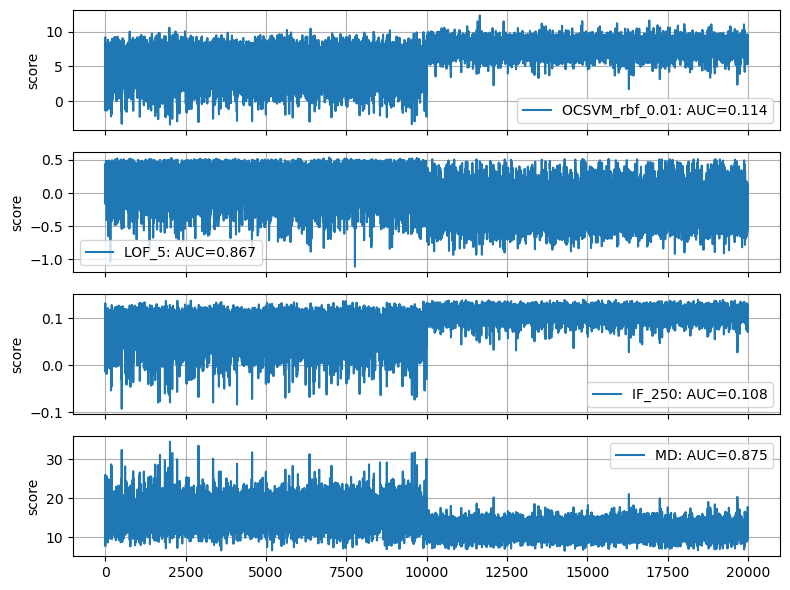

In [80]:
fig, ax = plt.subplots(len(detectors_dict.items()), sharex=True,
                       figsize=(8, 1.5*(len(detectors_dict.items()))))
for name, detector, ax_ in zip(detectors_dict.keys(), detectors_dict.values(), ax):
    scores = detector.fit(Xok_train).score(X_test)
    metric_value = detector.test(X_test, metric)
    ax_.plot(scores, label=f'{name}: {metric}={np.round(metric_value, 3)}')
    ax_.legend()
    ax_.grid()
    ax_.set(ylabel='score')
fig.tight_layout()
fig.savefig(f"scores_detectors_{layer}_PGD_defaultConfig.png")

In [84]:
dim_list = [64, 128]

attack_list = ['BIM', 'CW', 'PGD']


 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors_attacks=BIM/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000
No normalization info found
creating dataloader for:  test
closing test


KeyboardInterrupt: 

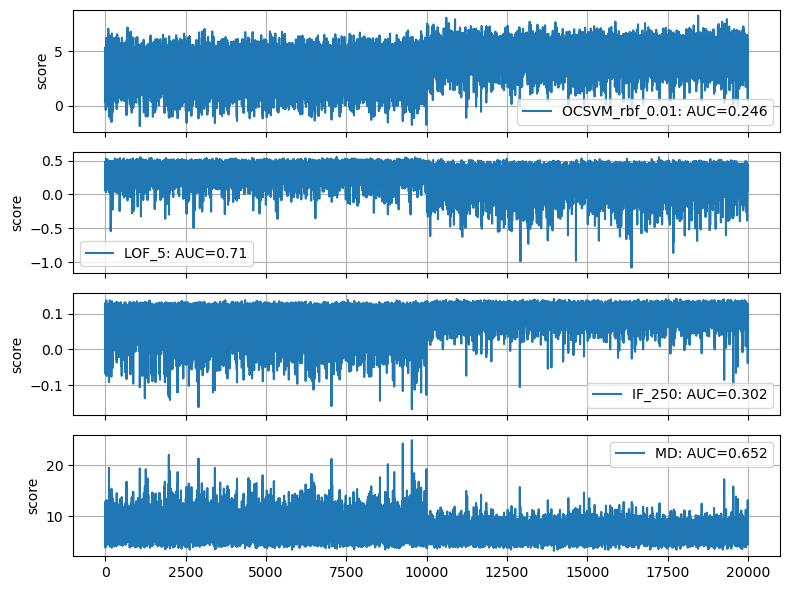

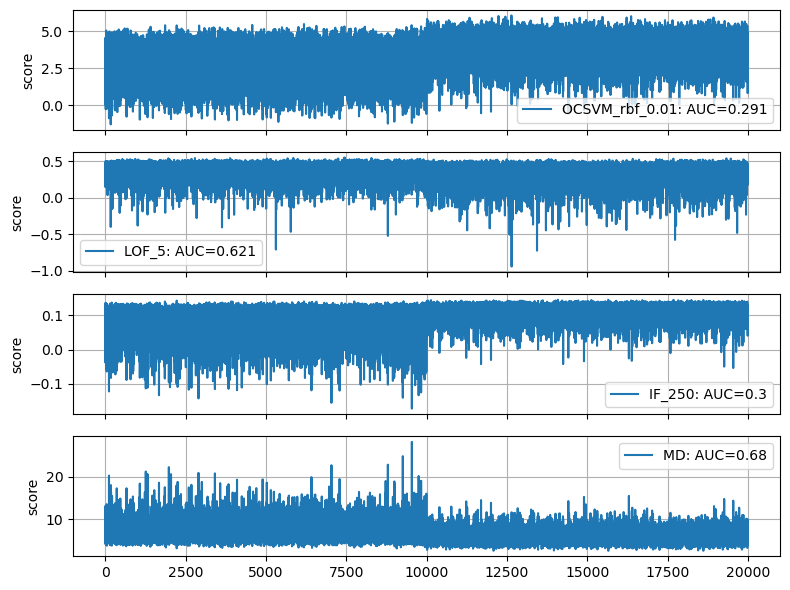

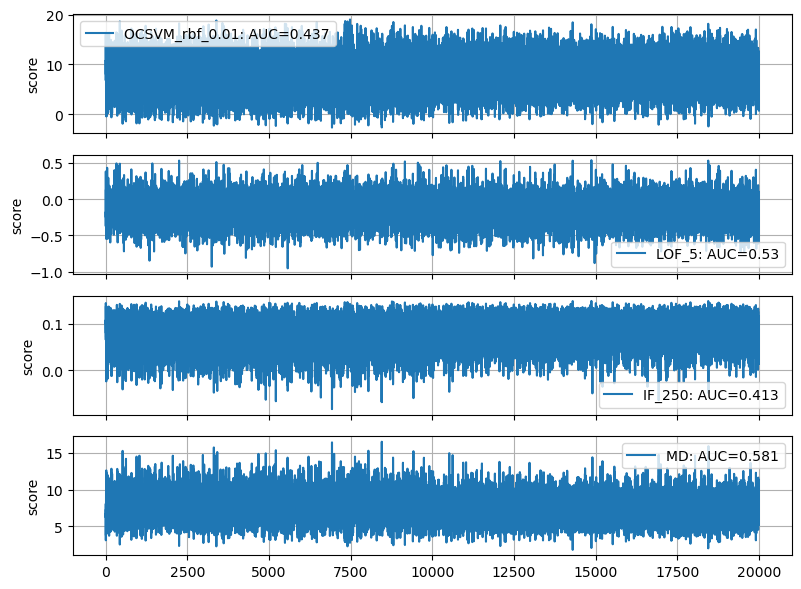

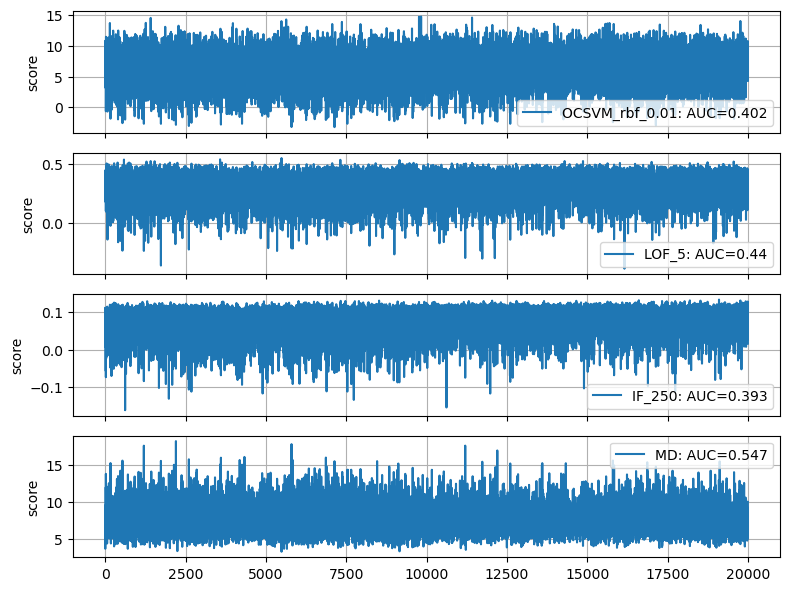

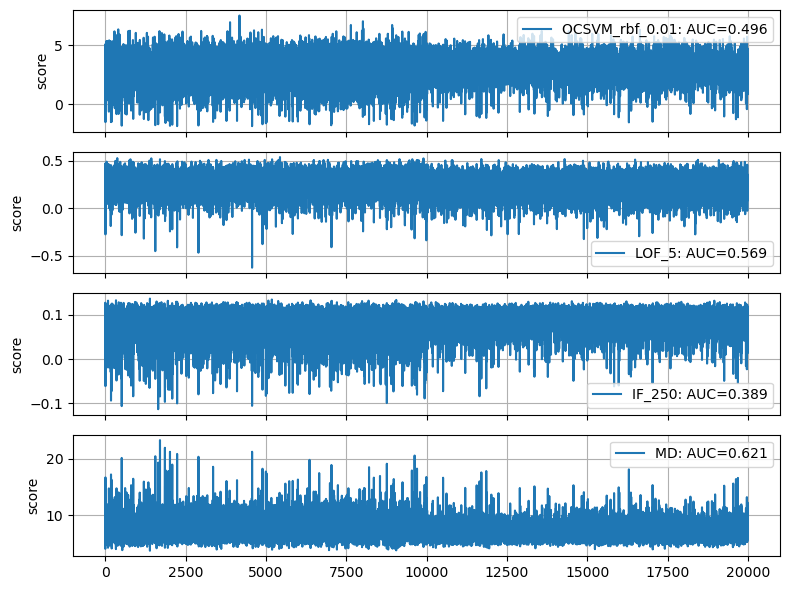

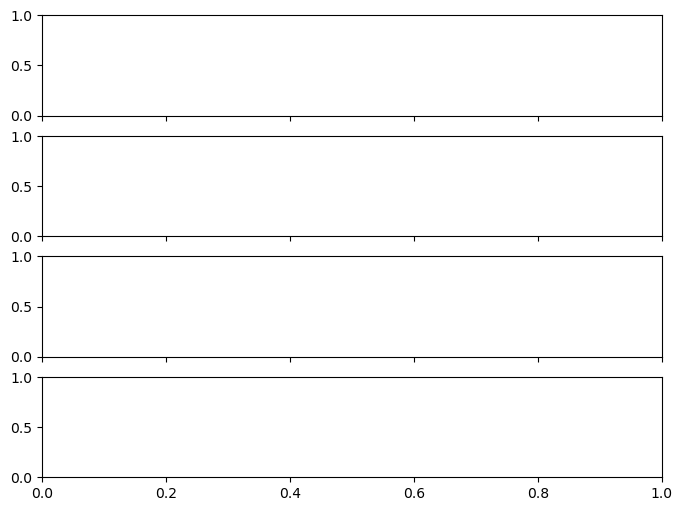

In [90]:
for atk_name in attack_list:
    cvs_name = 'corevectors'
    cvs_path = f'/srv/newpenny/XAI/generated_data/corevectors_attacks={atk_name}/{dataset}/{name_model}'
    
    corevecs = CoreVectors(
            path = cvs_path,
            name = cvs_name,
            model = model,
            device = device
            )
    
    # copy dataset to coreVect dataset
    with corevecs as cv:
        cv.load_only(
                loaders = ['test'],
                verbose = True
                ) 
    
        cv_dl = cv.get_dataloaders(
                batch_size = bs,
                verbose = True,
                )
        cva_test_dict = {key: corevectors for key, corevectors in cv_dl['test'].dataset['coreVectors'].items() }
        
    for dim in dim_list:
        path = Path.cwd()/f'../data/detectors_results/dim={dim}'
        os.makedirs(path, exist_ok=True)
        file_path = os.path.join(path, f'scores_detectors_{layer}_{atk_name}_defaultConfig.png')
            
        for layer in target_layers:
            Xok_train = cv_train_dict[layer][:,:dim].cpu().numpy()
    
            Xko_test = (cva_test_dict[layer][:,:dim]-means[layer][:dim])/stds[layer][:dim]
            Xok_test = cv_test_dict[layer][:,:dim].cpu().numpy()
            
            X_test = np.concatenate([Xok_test, Xko_test])
            fig, ax = plt.subplots(len(detectors_dict.items()), sharex=True,
                           figsize=(8, 1.5*(len(detectors_dict.items()))))
            for name, detector, ax_ in zip(detectors_dict.keys(), detectors_dict.values(), ax):
                scores = detector.fit(Xok_train).score(X_test)
                metric_value = detector.test(X_test, metric)
                ax_.plot(scores, label=f'{name}: {metric}={np.round(metric_value, 3)}')
                ax_.legend()
                ax_.grid()
                ax_.set(ylabel='score')
            fig.tight_layout()
            fig.savefig(file_path)

In [119]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt


In [151]:
dim_list = [8, 16, 32]
metric_list = ['P_D', 'AUC']
for dim in dim_list:
    for metric in metric_list:
        results = []

        for atk_name in attack_list:
            cvs_name = 'corevectors'
            cvs_path = f'/srv/newpenny/XAI/generated_data/corevectors_attacks={atk_name}/{dataset}/{name_model}'
            
            corevecs = CoreVectors(
                    path = cvs_path,
                    name = cvs_name,
                    model = model,
                    device = device
                    )
            
            # copy dataset to coreVect dataset
            with corevecs as cv:
                cv.load_only(
                        loaders = ['test'],
                        verbose = True
                        ) 
            
                cv_dl = cv.get_dataloaders(
                        batch_size = bs,
                        verbose = True,
                        )
                cva_test_dict = {key: corevectors for key, corevectors in cv_dl['test'].dataset['coreVectors'].items() }
                
            # for dim in dim_list:
            #     path = Path.cwd()/f'../data/detectors_results/dim={dim}'
            #     os.makedirs(path, exist_ok=True)
            #     file_path = os.path.join(path, f'scores_detectors_{layer}_{atk_name}_defaultConfig.png')
                    
            for layer in target_layers:
                Xok_train = cv_train_dict[layer][:,:dim].cpu().numpy()
        
                Xko_test = (cva_test_dict[layer][:,:dim]-means[layer][:dim])/stds[layer][:dim]
                Xok_test = cv_test_dict[layer][:,:dim].cpu().numpy()
                
                X_test = np.concatenate([Xok_test, Xko_test])
                for name, detector in zip(detectors_dict.keys(), detectors_dict.values()):
                    scores = detector.fit(Xok_train).score(X_test)
                    metric_value = detector.test(X_test, metric)
                    results.append({
                        "METHOD": name,
                        "LAYER": layer,
                        "ATTACK": atk_name,
                        "METRIC": np.round(metric_value, 3)  # Save the rounded metric value
                    })
        df = pd.DataFrame(results)
        df_pivot = df.pivot_table(
            index=["METHOD", "LAYER"],  # Rows
            columns="ATTACK",          # Columns
            values="METRIC",           # Values
            aggfunc='first'            # In case of duplicates, take the first value
        ).reset_index()
       
        df_pivot.to_csv(f"metric={metric}_dim={dim}.csv", index=False)



 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors_attacks=BIM/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000
No normalization info found
creating dataloader for:  test
closing test

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors_attacks=CW/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000
No normalization info found
creating dataloader for:  test
closing test

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors_attacks=PGD/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000
No normalization info found
creating dataloader for:  test
closing test

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors_attacks=BIM/CIFAR100/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000
No normalization info found
creating dataloader for:  test
closing test

 ---

In [141]:
df = pd.DataFrame(results)
df_pivot = df.pivot_table(
    index=["METHOD", "LAYER"],  # Rows
    columns="ATTACK",          # Columns
    values="METRIC",           # Values
    aggfunc='first'            # In case of duplicates, take the first value
).reset_index()

# Display the DataFrame
df_pivot

ATTACK,METHOD,LAYER,BIM,CW,PGD
0,IF_250,classifier.0,0.307,0.300,0.140
1,IF_250,classifier.3,0.296,0.192,0.219
2,IF_250,features.14,0.388,0.446,0.384
3,IF_250,features.28,0.343,0.411,0.165
4,IF_250,features.7,0.411,0.489,0.205
5,LOF_5,classifier.0,0.732,0.767,0.757
6,LOF_5,classifier.3,0.655,0.673,0.596
7,LOF_5,features.14,0.464,0.444,0.525
8,LOF_5,features.28,0.695,0.656,0.847
9,LOF_5,features.7,0.512,0.504,0.358


In [144]:
df_ = df_pivot.style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'})

In [143]:
df_pivot.to_csv(f"metric={metric}_dim={dim}.csv", index=False)